In [37]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import io
import sys

## Data cleaning and preparation

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -O data.csv

--2023-10-24 16:35:31--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'data.csv'

     0K .......... .......... .......... .......... ..........  3%  963K 1s
    50K .......... .......... .......... .......... ..........  7% 2.46M 1s
   100K .......... .......... .......... .......... .......... 10% 8.11M 1s
   150K .......... .......... .......... .......... .......... 14% 3.98M 1s
   200K .......... .......... .......... .......... .......... 17% 4.24M 0s
   250K .......... .......... .......... .......... .......... 21% 6.16M 0s
   300K .......... .......... .......... .......... .......... 25% 32.8M 0s
   350K .......... 

In [5]:
# Keeping only the records where 'ocean_proximity' is either '<1H OCEAN' or 'INLAND'
df = pd.read_csv("data.csv")
df = df[df["ocean_proximity"].isin(["<1H OCEAN", "INLAND"])]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [6]:
# Fill missing values with zeros
df = df.fillna(0)
# Apply the log transformation to the column 'median_house_value'
df["median_house_value"] = np.log1p(df["median_house_value"])
# Train-validation-test split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
# Reset the indices
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
# Create the target variable
y_full_train = df_full_train["median_house_value"].values
y_train = df_train["median_house_value"].values
y_val = df_val["median_house_value"].values
y_test = df_test["median_house_value"].values
# Delete the target variable from the datasets
del df_full_train["median_house_value"]
del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]
# Use the DictVectorizer class to turn the dataframes into matrices
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)
val_dict = df_val.to_dict(orient="records")
X_val = dv.transform(val_dict)
test_dict = df_test.to_dict(orient="records")
X_test = dv.transform(test_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [15]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.feature_names_))
# ANSWER: ocean_proximity=<1H OCEAN

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [21]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)
# ANSWER: 0.245

0.24459962783255346

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [22]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    scores.append({"n": n, "rmse": rmse})
df_scores = pd.DataFrame(scores)

<Axes: title={'center': 'RMSE vs. n_estimators'}, xlabel='n'>

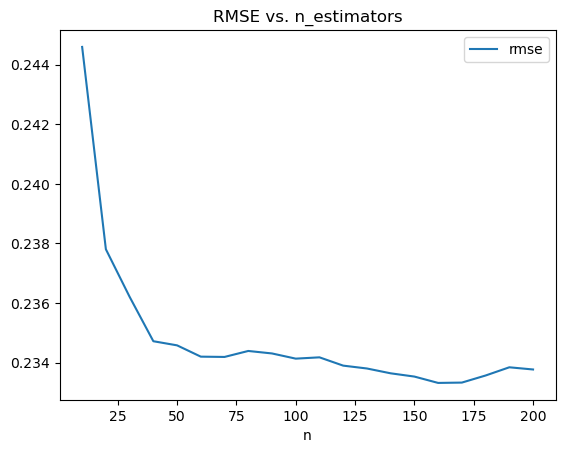

In [27]:
df_scores.plot(x="n", y="rmse", title="RMSE vs. n_estimators")
# ANSWER: 160

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [28]:
scores = []
for max_depth in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        scores.append({"max_depth": max_depth, "n": n, "rmse": rmse})
df_scores = pd.DataFrame(scores)

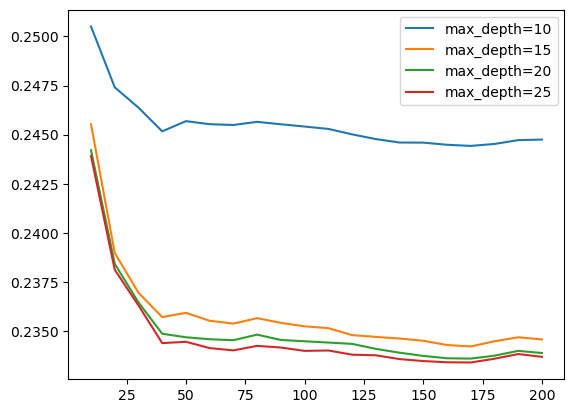

In [29]:
# RMSE vs n_estimators vs max_depth
for max_depth in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == max_depth]
    plt.plot(df_subset.n, df_subset.rmse, label="max_depth=%d" % max_depth)
plt.legend()

In [30]:
# Get mean RMSE for each value of max_depth
df_scores.groupby("max_depth")["rmse"].mean()

max_depth
10    0.245499
15    0.235816
20    0.235046
25    0.234713
Name: rmse, dtype: float64

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`


In [31]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [34]:
# Create feature importance dataframe
df_fi = pd.DataFrame(
    {"feature": dv.feature_names_, "importance": rf.feature_importances_}
)
df_fi.sort_values("importance", ascending=False)
# ANSWER: median_income

,feature,importance
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102665
3,longitude,0.085853
1,housing_median_age,0.030063
7,population,0.028115
9,total_rooms,0.021062
8,total_bedrooms,0.015434
0,households,0.015043


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [40]:
dv.feature_names_

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [46]:
# Prepare matrices for XGBoost
features = [
    f.replace("[", "").replace("]", "").replace("<", "") for f in dv.feature_names_
]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [47]:
def parse_xgb_output(output):
    # If stdout attribute doesn't exist, then take the whole output
    if not hasattr(output, "stdout"):
        output = output
    else:
        output = output.stdout
    results = []
    for line in output.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")
        it = int(it_line.strip("[]"))
        train = train_line.split(":")[1]
        val = val_line.split(":")[1]

        results.append(
            {
                "num_iteration": it,
                "train_auc": float(train),
                "val_auc": float(val),
            }
        )
    return pd.DataFrame(results)

In [48]:
watchlist = [(dtrain, "train"), (dval, "val")]
scores = {}
for eta in [0.01, 0.1, 0.3, 0.5, 0.75, 1]:
    with io.StringIO() as buf:
        xgb_params = {
            "eta": eta,
            "max_depth": 6,
            "min_child_weight": 1,
            "objective": "reg:squarederror",
            "nthread": 8,
            "seed": 1,
            "verbosity": 1,
        }
        sys.stdout = buf  # Redirect standard output to the buffer
        model = xgb.train(
            xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100
        )
        sys.stdout = sys.__stdout__  # Restore standard output
        output = buf.getvalue()  # Get the captured output from the buffer
        scores["eta=%s" % eta] = parse_xgb_output(output)

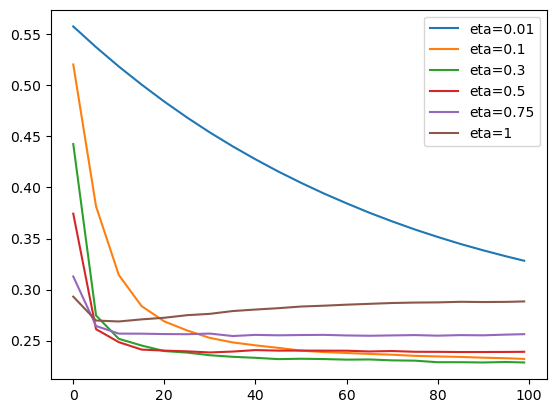

In [49]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iteration, df_score.val_auc, label=key)
plt.legend()
# ANSWER: eta=0.3